# Computer Vision in MXNet

Welcome to the tutorial! This tutorial will guide you through an example of Computer Vision on the MNIST dataset using MXNet. In the tutorial, we will cover: 
- What is an artificial neuron? 
- data loading and the MNIST data set
- convolutional layers, relu, and softmax layers 
- constructing a feed-forward model
- debugging 

First let's import the modules and setup logging:

In [1]:
%matplotlib inline
import mxnet as mx
import matplotlib.pyplot as plt
import logging

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

Next, we will cover our data and network architecture, MNIST and LeNet.

## MNIST Data
[MNIST](http://yann.lecun.com/exdb/mnist/) is a data set of handwritten digits with corresponding labels. You can think of each image as a 28x28 matrix, each of which is comprised of a greyscale value, and includes a <b> label </b> denoting the digit it contains. 

<b>Label:</b> 7 
<img src="images/im2mat.png">

## Data Loading

We can load the MNIST data from scikit and shuffle it to generate <b> test </b> and <b> training </b> sets.

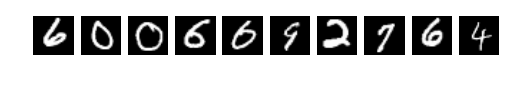

In [2]:
from sklearn.datasets import fetch_mldata
from sklearn.utils import shuffle
import tempfile
test_data_home = tempfile.mkdtemp()

mnist = fetch_mldata('MNIST original', data_home=test_data_home)

# shuffle data
X, y = shuffle(mnist.data, mnist.target)
# split dataset
train_data = X[:50000, :].astype('float32')
train_data = train_data.reshape((len(train_data), 1, 28, 28))
# train_X = train_X.reshape((len(train_X), 1, 28, 28))
train_label = y[:50000]
val_data = X[50000: 60000, :].astype('float32')
val_data = val_data.reshape((len(val_data), 1, 28, 28))
val_label = y[50000:60000]
# Normalize data
train_data[:] /= 256.0
val_data[:] /= 256.0

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(X[i].reshape((28,28)), cmap='Greys_r')
    plt.axis('off')
plt.show()

## LeNet

The LeNet is an early hallmark architecture on the MNIST data.
<img src="images/lenet.png">

LeCun, Yann, Leon Bottou, Yoshua Bengio, and Patrick Haffner. "Gradient-based learning applied to document recognition." Proceedings of the IEEE (1998)

In [3]:
# Define input layer
data = mx.symbol.Variable('data')

### Convolutional Layer

### Receptive Field, Kernel, and Stride
When we specify the <b>kernel</b> size, we are defining a “<b>receptive field</b>” or region of the image which we will use in an operation. One can also specify a stride to space out the receptive fields, although MXNet will use a (1,1) stride by default. 
<img src="https://thatindiandude.github.io/images/receptive_field.png">

Let k be the filter id. For each receptive field, we have a randomly initialized weight matrix such that, when multiplied by the receptive field, we have a real-valued constant result: $$I_{ij} * W_{ijk} = c \in \mathbb{R} $$


When $k$=1, then we will have the following feature map: 
<img src="https://thatindiandude.github.io/images/convolution.png">

When $k>1$, we apply multiple randomly initialized weights to the same receptive fields to result in several feature maps:
<img src="https://thatindiandude.github.io/images/multi_filter.png">

By keeping the weight matrices independent between filters, we hope that each one captures different features from the input image. We will “stack these” (indicated by the stacked rectangles in the LeNet architecture image) to build a 3-dimensional <b>tensor</b>:
<img src="https://thatindiandude.github.io/images/conv_output.png">

In [4]:
# first conv layer
conv1 = mx.symbol.Convolution(data=data, kernel=(5,5), num_filter=20)

### Activation
We then take the resulting tensor and apply an element-wise “activation” function. Using the $tanh$ function, we introduce non-linearity to the feature map.  
<img src="https://thatindiandude.github.io/images/activation_map.png">

In [5]:
tanh1 = mx.symbol.Activation(data=conv1, act_type="tanh")

### Pooling 

<img src="https://thatindiandude.github.io/images/pooling.png">

We will take another kernel (with stride) and take the max value of that kernel from the resulting activation map. Then, we stitch these together to create the pooling layer. In doing so, we downsample the convolutional output. 


In [6]:
pool1 = mx.symbol.Pooling(data=tanh1, pool_type="max",
                              kernel=(2,2), stride=(2,2))

In [7]:
# second conv
conv2 = mx.symbol.Convolution(data=pool1, kernel=(5,5), num_filter=50)
tanh2 = mx.symbol.Activation(data=conv2, act_type="tanh")
pool2 = mx.symbol.Pooling(data=tanh2, pool_type="max",
                          kernel=(2,2), stride=(2,2))

### Results

When we apply max-pooling, we want to find a feature in the activation map and to get rid of information regarding its locality. We don’t need this information because what matters is how the feature exists, relative to other locations of appearance close-by in the activation map rather than relative to the whole image. We can also reduce overhead in terms of the number of parameters needed to process the output from the convolution operation. 
 
When we apply the tanh function and pooling twice, the results may detect edges, corners, and dots in a first layer, and higher level features in the second layer due to more non-linearity. 

Jarrett et al. use tanh and absolute value pooling to detect edges  

<img src="https://thatindiandude.github.io/images/jarrett.png">


### Fully Connected Layers
As opposed to the convolutional layer, in which receptive fields are only connected to spatially local ones, a fully connected layer will connect all receptive fields from the last layer to construct its activation maps. 

<img src="https://thatindiandude.github.io/images/fc_layer.jpeg">


In [8]:
# first fully connected layer
flatten = mx.symbol.Flatten(data=pool2)
fc1 = mx.symbol.FullyConnected(data=flatten, num_hidden=500)
tanh3 = mx.symbol.Activation(data=fc1, act_type="tanh")

By flattening the pooling later, we can create a flat representation of an embedding of an input image. Then, by using a fully connected layer, we will release the constraint on spatial locality and enable features to mix. 

Then, by using a 10-unit FC layer, we will have a neuron which is accurate in predicting of one each digit.

In [9]:
# second fully connected layer
fc2 = mx.symbol.FullyConnected(data=tanh3, num_hidden=10)

### Softmax Prediction
Now that we have 10 neurons from which to make predictions, we will use softmax prediction to actually find the most likely digit in an input $x$.

#### Process
1. Determine case for input being a digit pixel by pixel 
2. Establish probabilities per digit

##### Determine Case
For each digit $i$ (0...9), the case is calculated for each pixel $j$ using weight $W_{j}$. We also have a bias term $b$ added per digit. Then, we want to exponentiate this. 

$$case_i = \exp{(\sum_{j}W_{i,j}x_j + b_i})$$ 

##### Establish Probability

Then, we will normalize the case across all digits to establish probabilities. Overall all classes $j$: 

$$softmax(x) = [ \frac{\exp{x_0}}{\sum_{j}\exp{x_j}}, \frac{\exp{x_1}}{\sum_{j}\exp{x_j}}, ... ] $$

In [10]:
# loss
lenet = mx.symbol.SoftmaxOutput(data=fc2, name='softmax')

# Running a Model
Now that we have created a model, we can now run a model. First, we will need an iterator to load our data at an appropriate batch size. 

In [11]:
# create a numpy iterator
batch_size = 100
train_iter = mx.io.NDArrayIter(train_data, train_label, batch_size=batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(val_data, val_label, batch_size=batch_size)

Then we can run the model with several input parameters, including (but not limited to):
- context: where to run the model, either CPU(s) or GPU(s)
- symbol: model 
- learning_rate: how fast are weights adjusted
- momentum: how much to weigh the rate of change in the gradients

In [12]:
model = mx.model.FeedForward(
    ctx = mx.cpu(), 
    symbol = lenet,
    num_epoch = 10,       # Train for 10 epochs
    learning_rate = 0.1,  # Learning rate
    momentum = 0.9,       # Momentum for SGD with momentum
    wd = 0.00001 
)

model.fit(X = train_iter, eval_data = val_iter, batch_end_callback = mx.callback.Speedometer(batch_size, 200))

INFO:root:Start training with [cpu(0)]
INFO:root:Iter[0] Batch [200]	Speed: 430.46 samples/sec
INFO:root:Iter[0] Batch [400]	Speed: 428.22 samples/sec
INFO:root:Epoch[0] Train-accuracy=0.718040
INFO:root:Epoch[0] Time cost=116.891
INFO:root:Epoch[0] Validation-accuracy=0.966100
INFO:root:Iter[1] Batch [200]	Speed: 364.30 samples/sec
INFO:root:Iter[1] Batch [400]	Speed: 369.39 samples/sec
INFO:root:Epoch[1] Train-accuracy=0.975140
INFO:root:Epoch[1] Time cost=133.783
INFO:root:Epoch[1] Validation-accuracy=0.978400
INFO:root:Iter[2] Batch [200]	Speed: 409.41 samples/sec
INFO:root:Iter[2] Batch [400]	Speed: 388.86 samples/sec
INFO:root:Epoch[2] Train-accuracy=0.985840
INFO:root:Epoch[2] Time cost=124.780
INFO:root:Epoch[2] Validation-accuracy=0.984300
INFO:root:Iter[3] Batch [200]	Speed: 431.88 samples/sec
INFO:root:Iter[3] Batch [400]	Speed: 426.02 samples/sec
INFO:root:Epoch[3] Train-accuracy=0.990380
INFO:root:Epoch[3] Time cost=116.868
INFO:root:Epoch[3] Validation-accuracy=0.983800
I

# Test and Debug
We can print out the following test run: 

In [ ]:
import numpy as np

plt.imshow((X[0].reshape((28,28))*255).astype(np.uint8), cmap='Greys_r')
plt.show()
print 'Result:', model.predict((X[0].reshape((28,28))*255))

We can also evaluate the model's accuracy on the entire test set:

In [ ]:
print 'Accuracy:', model.score(test_iter)*100, '%'

Now, try if your model recognizes your own hand writing.
Write a digit from 0 to 9 in the box below. Try to put your digit in the middle of the box.

In [18]:
# run hand drawing test
from IPython.display import HTML

def classify(img):
    img = img[len('data:image/png;base64,'):].decode('base64')
    img = cv2.imdecode(np.fromstring(img, np.uint8), -1)
    img = cv2.resize(img[:,:,3], (28,28))
    img = img.astype(np.float32).reshape((1, 784))/255.0
    return model.predict(img)[0].argmax()

html = """<style type="text/css">canvas { border: 1px solid black; }</style><div id="board"><canvas id="myCanvas" width="100px" height="100px">Sorry, your browser doesn't support canvas technology.</canvas><p><button id="classify" onclick="classify()">Classify</button><button id="clear" onclick="myClear()">Clear</button>Result: <input type="text" id="result_output" size="5" value=""></p></div>"""
script = """<script type="text/JavaScript" src="https://ajax.googleapis.com/ajax/libs/jquery/1.4.2/jquery.min.js?ver=1.4.2"></script><script type="text/javascript">function init() {var myCanvas = document.getElementById("myCanvas");var curColor = $('#selectColor option:selected').val();if(myCanvas){var isDown = false;var ctx = myCanvas.getContext("2d");var canvasX, canvasY;ctx.lineWidth = 8;$(myCanvas).mousedown(function(e){isDown = true;ctx.beginPath();var parentOffset = $(this).parent().offset(); canvasX = e.pageX - parentOffset.left;canvasY = e.pageY - parentOffset.top;ctx.moveTo(canvasX, canvasY);}).mousemove(function(e){if(isDown != false) {var parentOffset = $(this).parent().offset(); canvasX = e.pageX - parentOffset.left;canvasY = e.pageY - parentOffset.top;ctx.lineTo(canvasX, canvasY);ctx.strokeStyle = curColor;ctx.stroke();}}).mouseup(function(e){isDown = false;ctx.closePath();});}$('#selectColor').change(function () {curColor = $('#selectColor option:selected').val();});}init();function handle_output(out) {document.getElementById("result_output").value = out.content.data["text/plain"];}function classify() {var kernel = IPython.notebook.kernel;var myCanvas = document.getElementById("myCanvas");data = myCanvas.toDataURL('image/png');document.getElementById("result_output").value = "";kernel.execute("classify('" + data +"')",  { 'iopub' : {'output' : handle_output}}, {silent:false});}function myClear() {var myCanvas = document.getElementById("myCanvas");myCanvas.getContext("2d").clearRect(0, 0, myCanvas.width, myCanvas.height);}</script>"""
HTML(html+script)